# CS5100 Group Project

### Import libraries

In [90]:
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,15
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

### Read the dataset

In [91]:
#Read the dataset for NFLX
df=pd.read_csv("NFLX.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-16,309.940002,310.489990,303.609985,306.019989,306.019989,8038600
1,2022-11-15,309.200012,312.709991,302.549988,310.200012,310.200012,14626900
2,2022-11-14,290.000000,311.000000,288.190002,299.269989,299.269989,17978200
3,2022-11-11,274.470001,290.660004,271.559998,290.130005,290.130005,9567300
4,2022-11-10,265.989990,275.359985,260.089996,274.970001,274.970001,9667300


In [92]:
#Read the dataset for AAPL
df1=pd.read_csv("AAPL.csv")
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2017-11-17,42.759998,42.847500,42.410000,42.537498,40.448898,87598000,AAPL
1,2017-11-20,42.572498,42.639999,42.389999,42.494999,40.408474,65049600,AAPL
2,2017-11-21,42.695000,43.424999,42.695000,43.285000,41.159695,100525200,AAPL
3,2017-11-22,43.340000,43.750000,43.262501,43.740002,41.592350,102355600,AAPL
4,2017-11-24,43.775002,43.875000,43.662498,43.742500,41.594727,56106800,AAPL


In [93]:
#Read the dataset for META
df2=pd.read_csv("META.csv")
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2017-11-17,179.300003,179.979996,178.899994,179.000000,179.000000,13018000,META
1,2017-11-20,178.869995,179.500000,178.100006,178.740005,178.740005,10052400,META
2,2017-11-21,179.149994,181.889999,178.990005,181.860001,181.860001,14504000,META
3,2017-11-22,181.300003,181.729996,180.440002,180.869995,180.869995,10376300,META
4,2017-11-24,180.399994,183.149994,180.289993,182.779999,182.779999,9426300,META


In [94]:
#Read the dataset for AAPL
df3=pd.read_csv("MSFT.csv")
df3.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2017-11-17,83.120003,83.120003,82.239998,82.400002,77.597290,22079000,MSFT
1,2017-11-20,82.400002,82.589996,82.250000,82.529999,77.719711,16315000,MSFT
2,2017-11-21,82.739998,83.839996,82.739998,83.720001,78.840370,21237500,MSFT
3,2017-11-22,83.830002,83.900002,83.040001,83.110001,78.265923,20553100,MSFT
4,2017-11-24,83.010002,83.430000,82.779999,83.260002,78.407181,7425600,MSFT


In [95]:
#Read the dataset for AAPL
df4=pd.read_csv("TSLA.csv")
df4.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2017-11-17,21.711332,21.778000,20.876667,21.003332,21.003332,206026500,TSLA
1,2017-11-20,20.919333,21.033333,20.316668,20.582666,20.582666,123715500,TSLA
2,2017-11-21,20.724001,21.215334,20.580667,21.187332,21.187332,108919500,TSLA
3,2017-11-22,21.118000,21.161333,20.789333,20.840000,20.840000,73764000,TSLA
4,2017-11-24,20.919333,21.094000,20.733334,21.036667,21.036667,48661500,TSLA


### Analyze the closing prices from dataframe

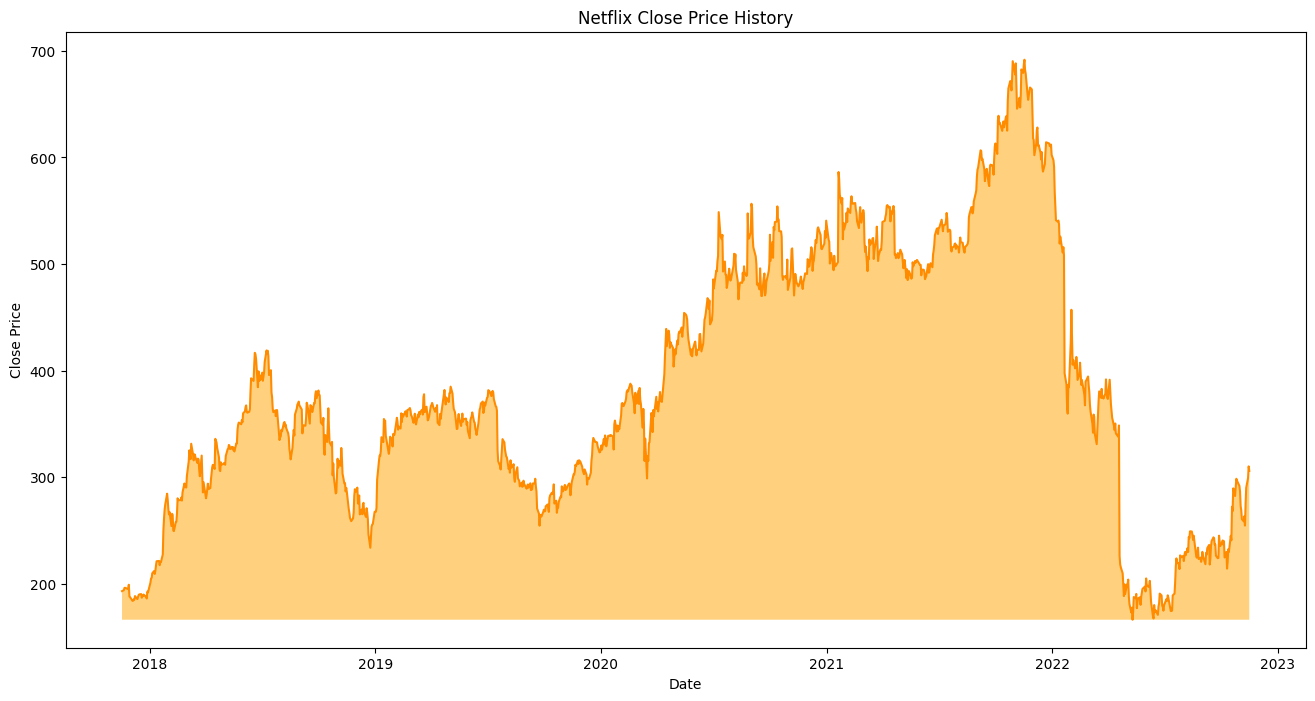

In [96]:
#Analyze the Netflix closing prices from datafrram
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
Closemin = df.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='NFLX Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Netflix Close Price History")
plt.fill_between(df.index, Closemin, df.Close, facecolor='orange', alpha = 0.5)

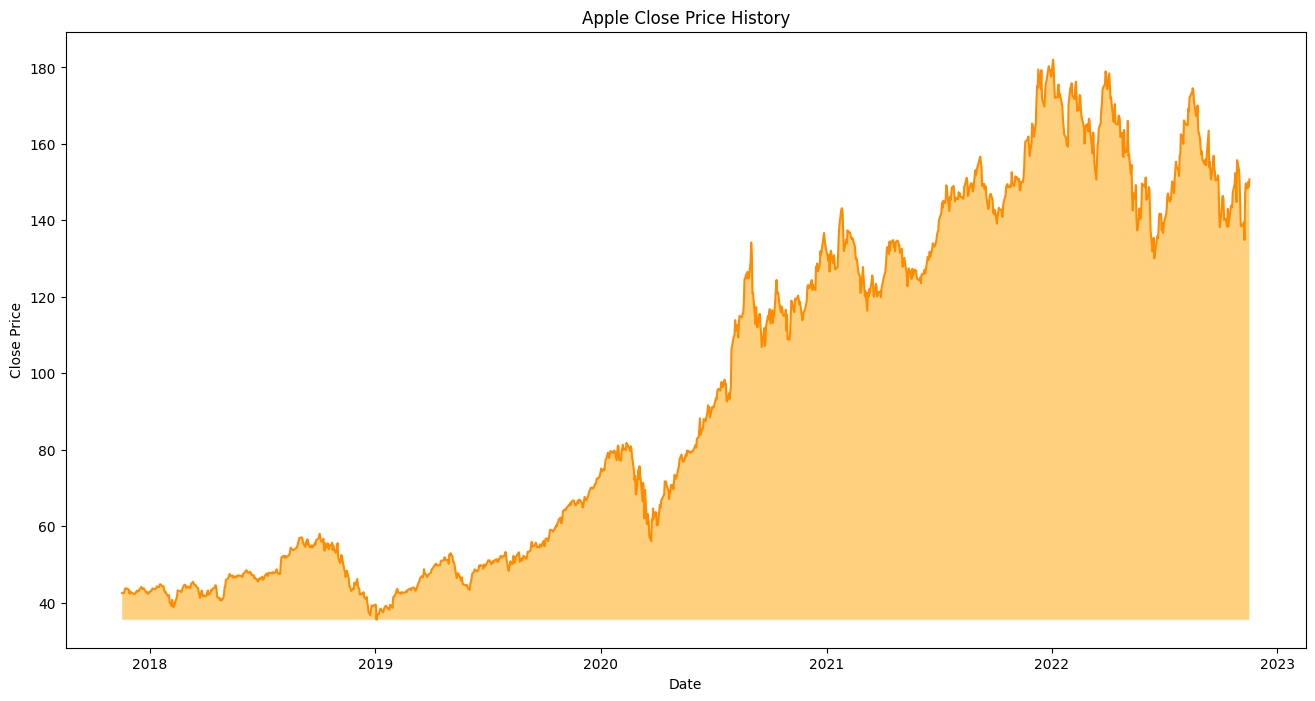

In [97]:
#Analyze the Apple closing prices from dataframe
df1["Date"]=pd.to_datetime(df1.Date,format="%Y-%m-%d")
df1.index=df1['Date']
Closemin = df1.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df1["Close"],label='Apple Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Apple Close Price History")
plt.fill_between(df1.index, Closemin, df1.Close, facecolor='orange', alpha = 0.5)

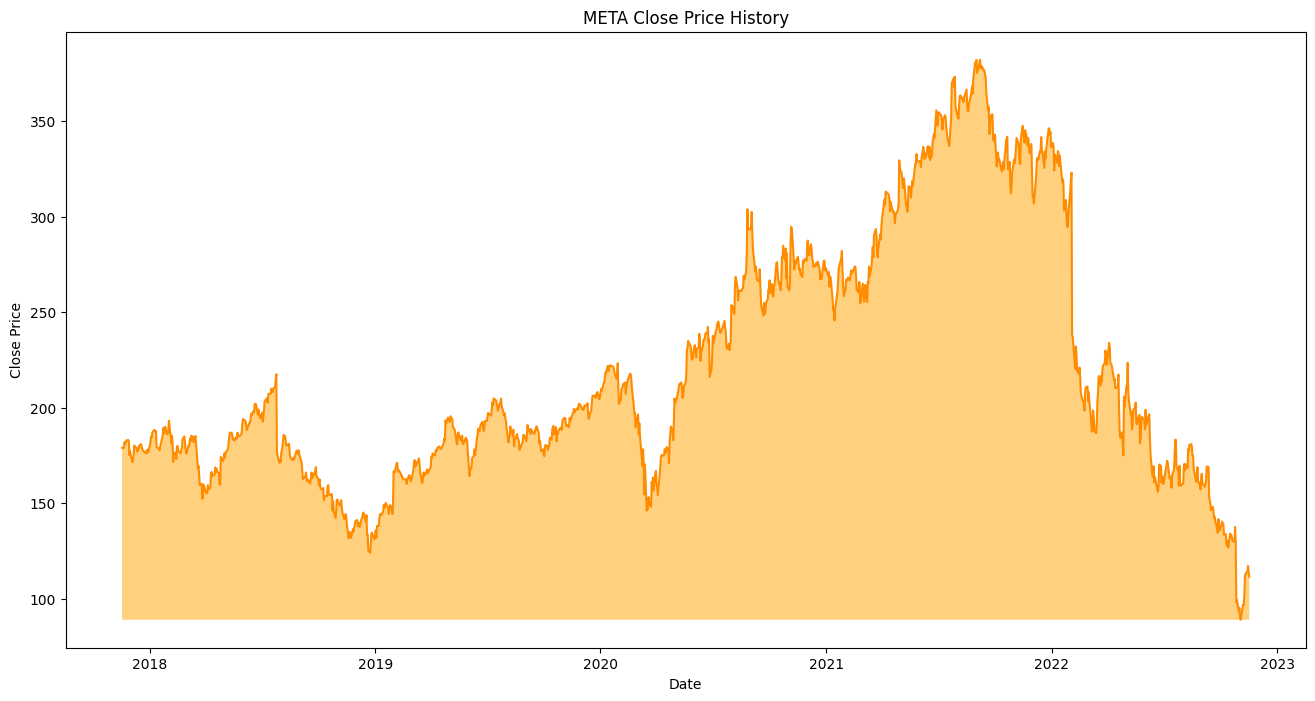

In [118]:
#Analyze the META closing prices from dataframe
df2["Date"]=pd.to_datetime(df2.Date,format="%Y-%m-%d")
df2.index=df2['Date']
Closemin = df2.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df2["Close"],label='META Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("META Close Price History")
plt.fill_between(df2.index, Closemin, df2.Close, facecolor='orange', alpha = 0.5)

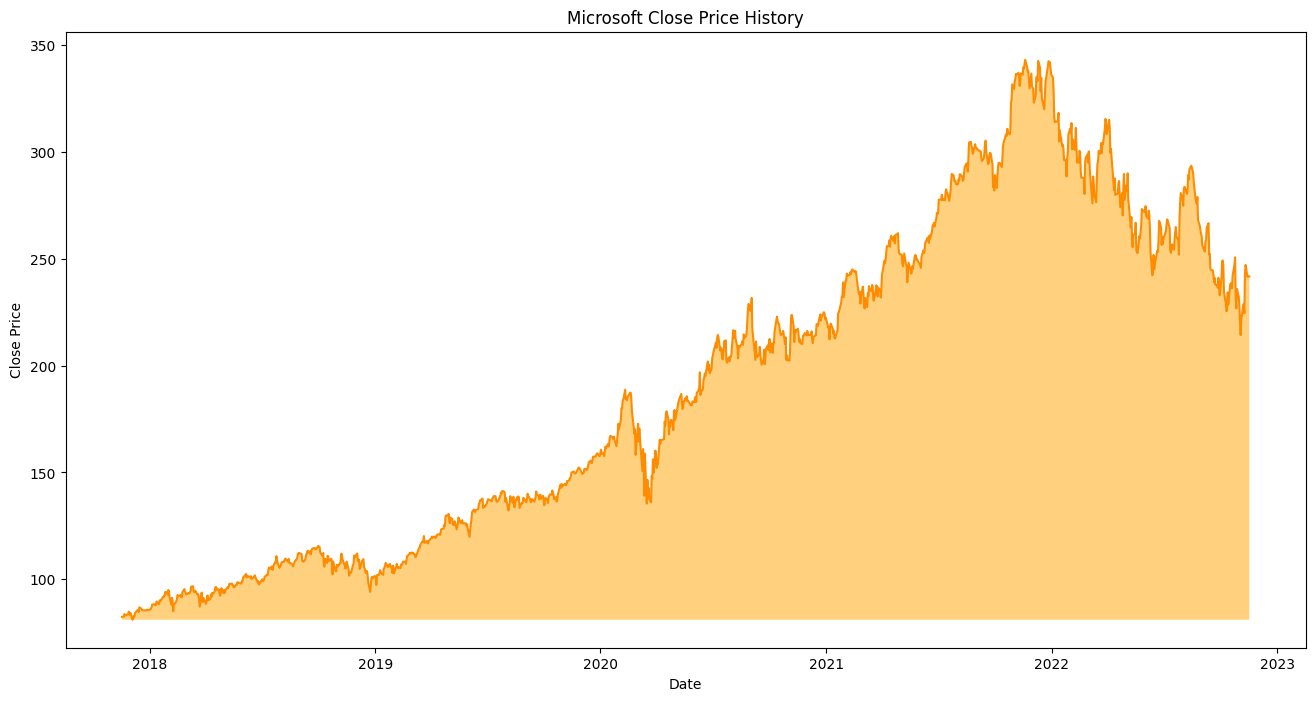

In [99]:
#Analyze the Microsoft closing prices from dataframe
df3["Date"]=pd.to_datetime(df3.Date,format="%Y-%m-%d")
df3.index=df3['Date']
Closemin = df3.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df3["Close"],label='MSFT Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Microsoft Close Price History")
plt.fill_between(df3.index, Closemin, df3.Close, facecolor='orange', alpha = 0.5)

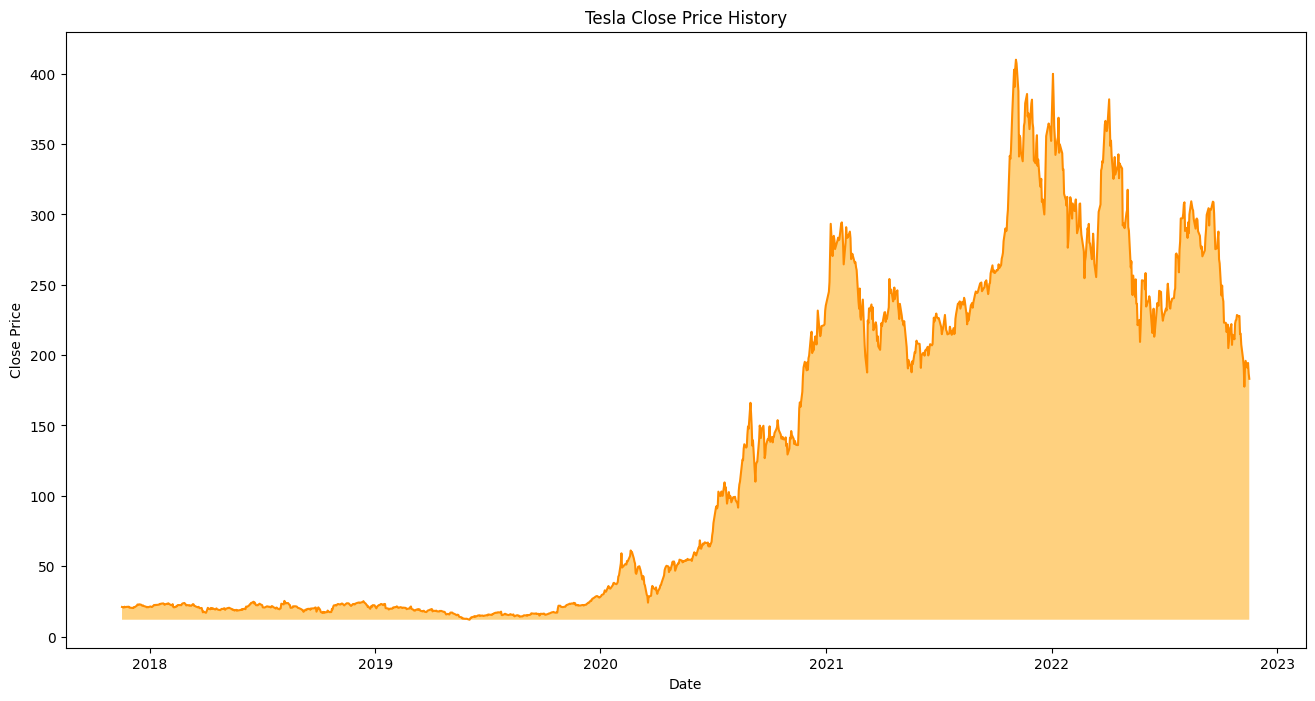

In [100]:
#Analyze the Tesla closing prices from dataframe
df4["Date"]=pd.to_datetime(df4.Date,format="%Y-%m-%d")
df4.index=df4['Date']
Closemin = df4.Close.min()
plt.figure(figsize=(16,8))
plt.plot(df4["Close"],label='Tesla Close Price History', color='darkorange')
plt.xlabel('Date')
plt.ylabel('Close Price')

# displaying the title
plt.title("Tesla Close Price History")
plt.fill_between(df4.index, Closemin, df4.Close, facecolor='orange', alpha = 0.5)

### Build and train the LSTM model for Netflix

In [ ]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset=new_dataset.values

train_data=final_dataset[0:1007,:]
valid_data=final_dataset[1007:,:]

scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

#Build and train the LSTM model:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

2022-11-21 21:35:20.587882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:35:20.745604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:35:20.870293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:35:21.020457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:35:21.184789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

2022-11-21 21:34:20.161671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:34:20.236301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:34:20.346785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 33ms/step


/var/folders/p9/5_9zfv8x779996pp8x3dr8hr0000gn/T/ipykernel_84498/1638199167.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


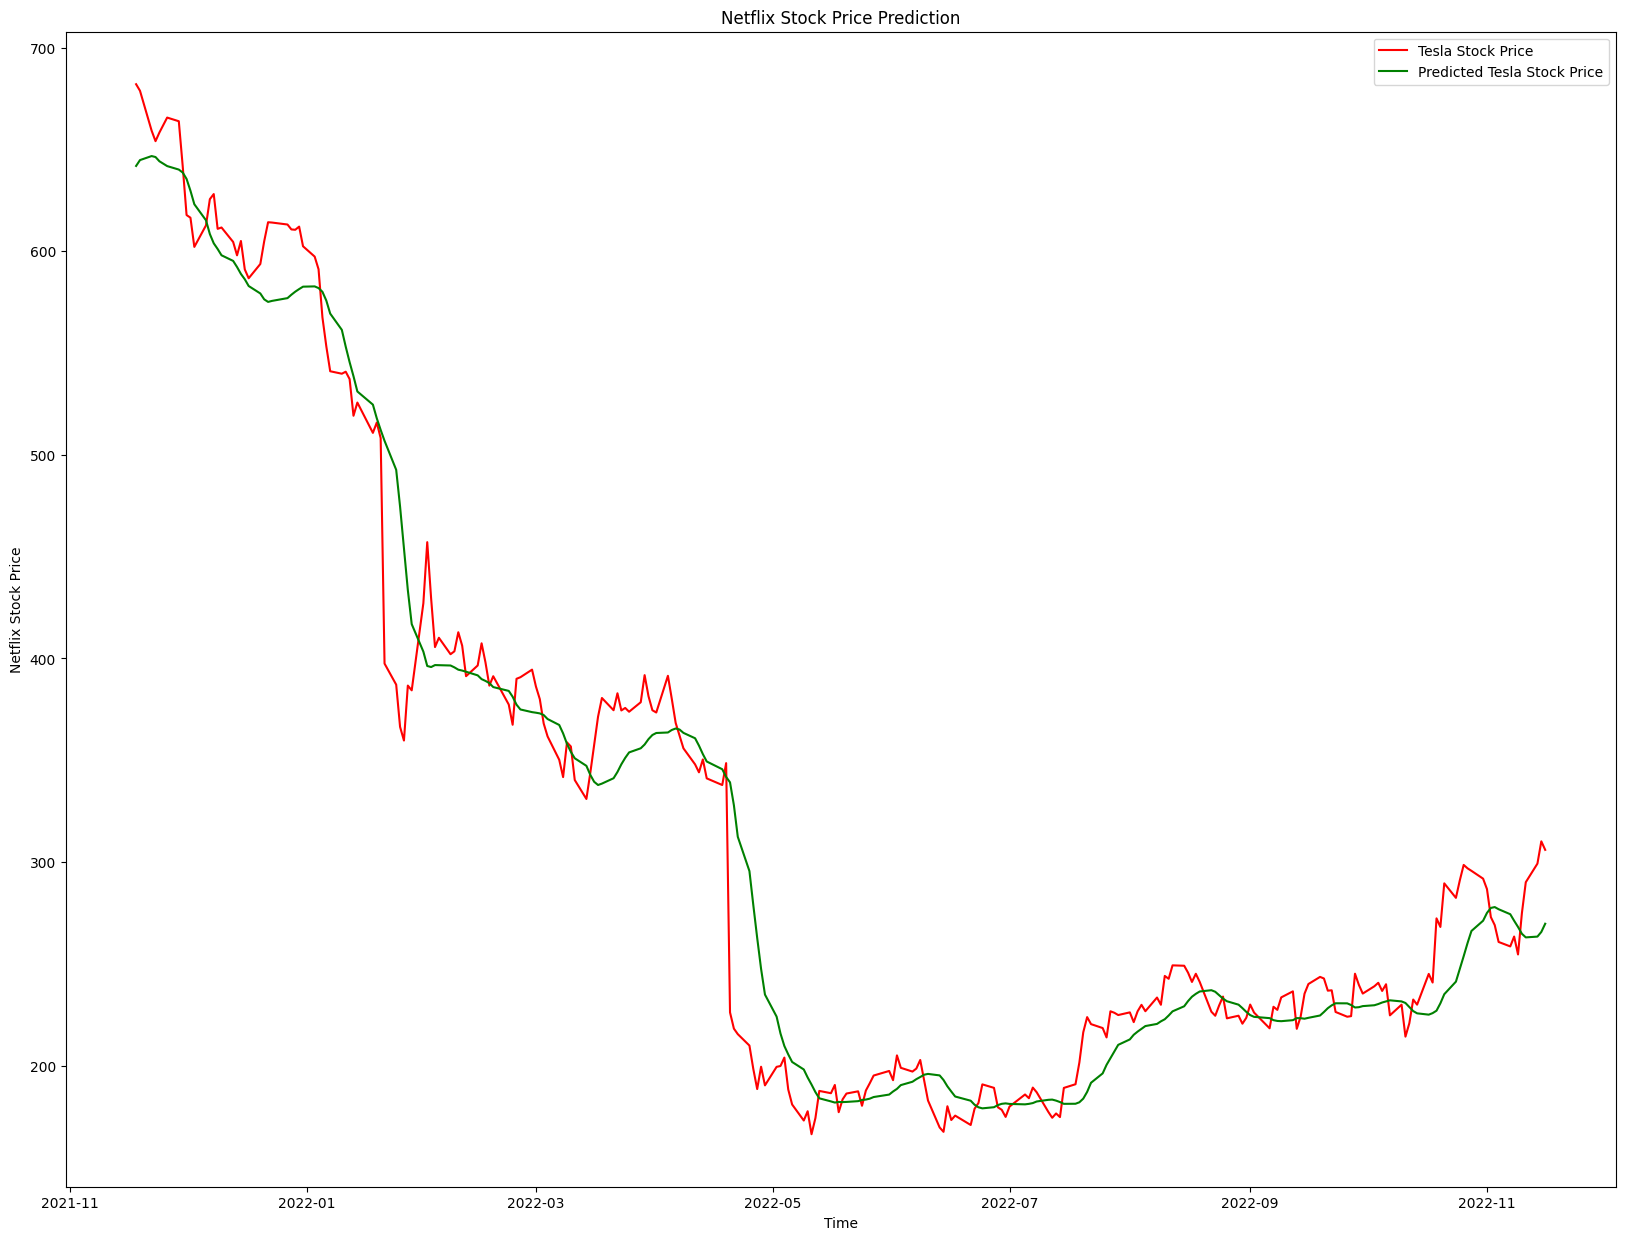

In [ ]:
#Save the LSTM model
lstm_model.save("saved_model_NFLX.h5")

#Visualize the predicted stock costs with actual stock costs
train_data=new_dataset[:1007]
valid_data=new_dataset[1007:]

valid_data['Predictions']=predicted_closing_price
plt.plot(valid_data['Close'], color = 'red', label = 'Tesla Stock Price')
plt.plot(valid_data['Predictions'], color = 'green', label = 'Predicted Tesla Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price')

# displaying the title
plt.title("Netflix Stock Price Prediction")
plt.show()


### Build and train the LSTM model for Apple

In [106]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data1=df1.sort_index(ascending=True,axis=0)
new_dataset1=pd.DataFrame(index=range(0,len(df1)),columns=['Date','Close'])
for i in range(0,len(data1)):
    new_dataset1["Date"][i]=data1['Date'][i]
    new_dataset1["Close"][i]=data1["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset1.index=new_dataset1.Date
new_dataset1.drop("Date",axis=1,inplace=True)
final_dataset1=new_dataset1.values

train_data1=final_dataset1[0:1007,:]
valid_data1=final_dataset1[1007:,:]

scaled_data1=scaler.fit_transform(final_dataset1)
x_train_data1,y_train_data1=[],[]
for i in range(60,len(train_data1)):
    x_train_data1.append(scaled_data1[i-60:i,0])
    y_train_data1.append(scaled_data1[i,0])

x_train_data1,y_train_data1=np.array(x_train_data1),np.array(y_train_data1)
x_train_data1=np.reshape(x_train_data1,(x_train_data1.shape[0],x_train_data1.shape[1],1))

#Build and train the LSTM model:
lstm_model1=Sequential()
lstm_model1.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data1.shape[1],1)))
lstm_model1.add(LSTM(units=50))
lstm_model1.add(Dense(1))
inputs_data1=new_dataset1[len(new_dataset1)-len(valid_data1)-60:].values
inputs_data1=inputs_data1.reshape(-1,1)
inputs_data1=scaler.transform(inputs_data1)
lstm_model1.compile(loss='mean_squared_error',optimizer='adam')
lstm_model1.fit(x_train_data1,y_train_data1,epochs=1,batch_size=1,verbose=2)

2022-11-21 21:42:06.394828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:42:06.552097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:42:06.676030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:42:06.852771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:42:07.020407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


947/947 - 29s - loss: 0.0021 - 29s/epoch - 31ms/step


8/8 [==============================] - 0s 20ms/step


/var/folders/p9/5_9zfv8x779996pp8x3dr8hr0000gn/T/ipykernel_84498/1767354640.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data1['Predictions']=predicted_closing_price1


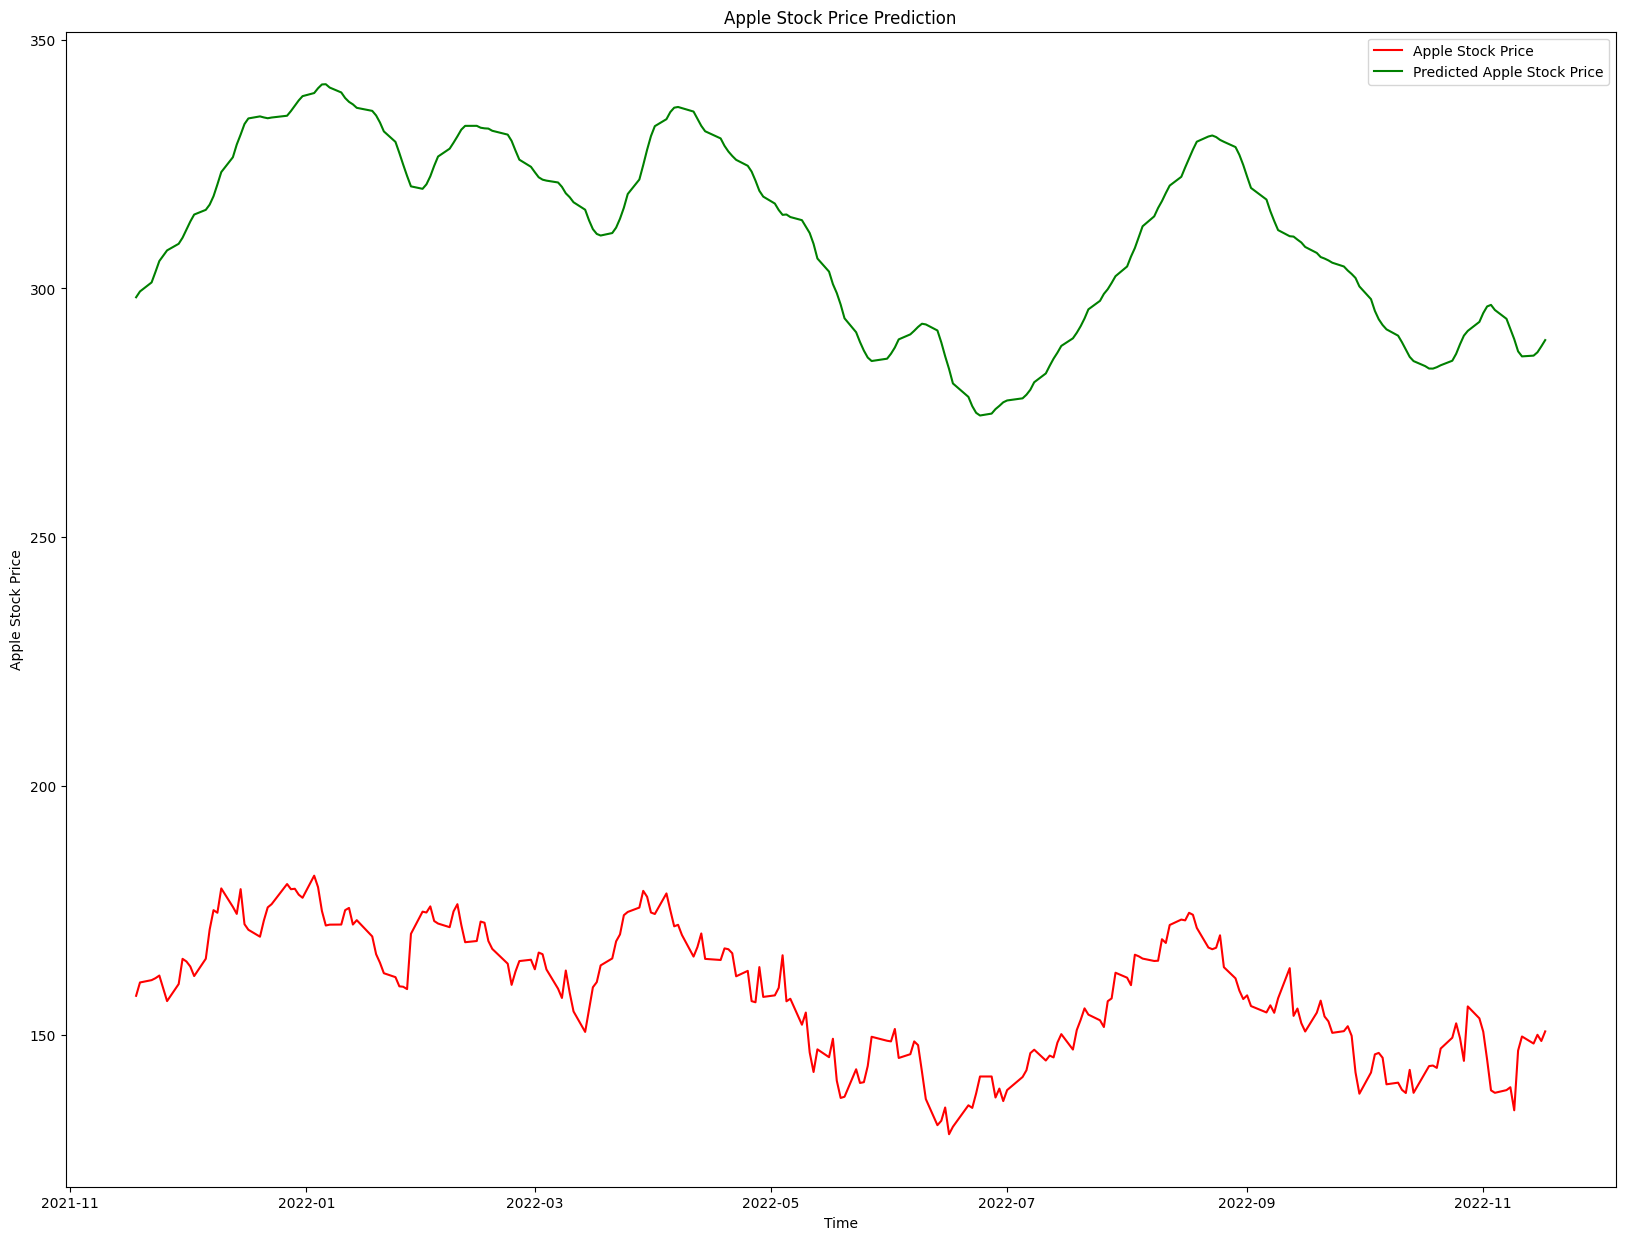

In [116]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test1=[]
for i in range(60,inputs_data1.shape[0]):
    X_test1.append(inputs_data1[i-60:i,0])
X_test1=np.array(X_test1)
X_test1=np.reshape(X_test1,(X_test1.shape[0],X_test1.shape[1],1))
predicted_closing_price1=lstm_model1.predict(X_test1)
predicted_closing_price1=scaler.inverse_transform(predicted_closing_price1)
#Save the LSTM model
lstm_model1.save("saved_model_AAPL.h5")

#Visualize the predicted stock costs with actual stock costs
train_data1=new_dataset1[:1007]
valid_data1=new_dataset1[1007:]
valid_data1['Predictions']=predicted_closing_price1
#plt.plot(train_data1["Close"])
#plt.plot(valid_data1[['Close',"Predictions"]])
plt.plot(valid_data1['Close'], color = 'red', label = 'Apple Stock Price')
plt.plot(valid_data1['Predictions'], color = 'green', label = 'Predicted Apple Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')

# displaying the title
plt.title("Apple Stock Price Prediction")
plt.show()


### Build and train the LSTM model for META

In [120]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data2=df2.sort_index(ascending=True,axis=0)
new_dataset2=pd.DataFrame(index=range(0,len(df2)),columns=['Date','Close'])
for i in range(0,len(data2)):
    new_dataset2["Date"][i]=data2['Date'][i]
    new_dataset2["Close"][i]=data2["Close"][i]




In [121]:
#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset2.index=new_dataset2.Date
new_dataset2.drop("Date",axis=1,inplace=True)
final_dataset2=new_dataset2.values

train_data2=final_dataset2[0:1007,:]
valid_data2=final_dataset2[1007:,:]

scaled_data2=scaler.fit_transform(final_dataset2)
x_train_data2,y_train_data2=[],[]
for i in range(60,len(train_data2)):
    x_train_data2.append(scaled_data2[i-60:i,0])
    y_train_data2.append(scaled_data2[i,0])

x_train_data2,y_train_data1=np.array(x_train_data2),np.array(y_train_data2)
x_train_data2=np.reshape(x_train_data2,(x_train_data2.shape[0],x_train_data2.shape[1],1))



In [123]:
#Build and train the LSTM model:
lstm_model2=Sequential()
lstm_model2.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
lstm_model2.add(LSTM(units=50))
lstm_model2.add(Dense(1))
inputs_data2=new_dataset2[len(new_dataset2)-len(valid_data2)-60:].values
inputs_data2=inputs_data2.reshape(-1,1)
inputs_data2=scaler.transform(inputs_data2)
lstm_model2.compile(loss='mean_squared_error',optimizer='adam')
lstm_model2.fit(np.asarray(x_train_data2),np.asarray(y_train_data2),epochs=1,batch_size=1,verbose=2)

2022-11-21 21:54:52.608135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:54:52.774785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:54:52.920176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:54:53.075773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:54:53.241390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


947/947 - 30s - loss: 0.0024 - 30s/epoch - 32ms/step


2022-11-21 21:57:03.284087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 21:57:03.428864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/8 [==============>...............] - ETA: 0s

2022-11-21 21:57:03.610598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 84ms/step


/var/folders/p9/5_9zfv8x779996pp8x3dr8hr0000gn/T/ipykernel_84498/1142219667.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data2['Predictions']=predicted_closing_price2


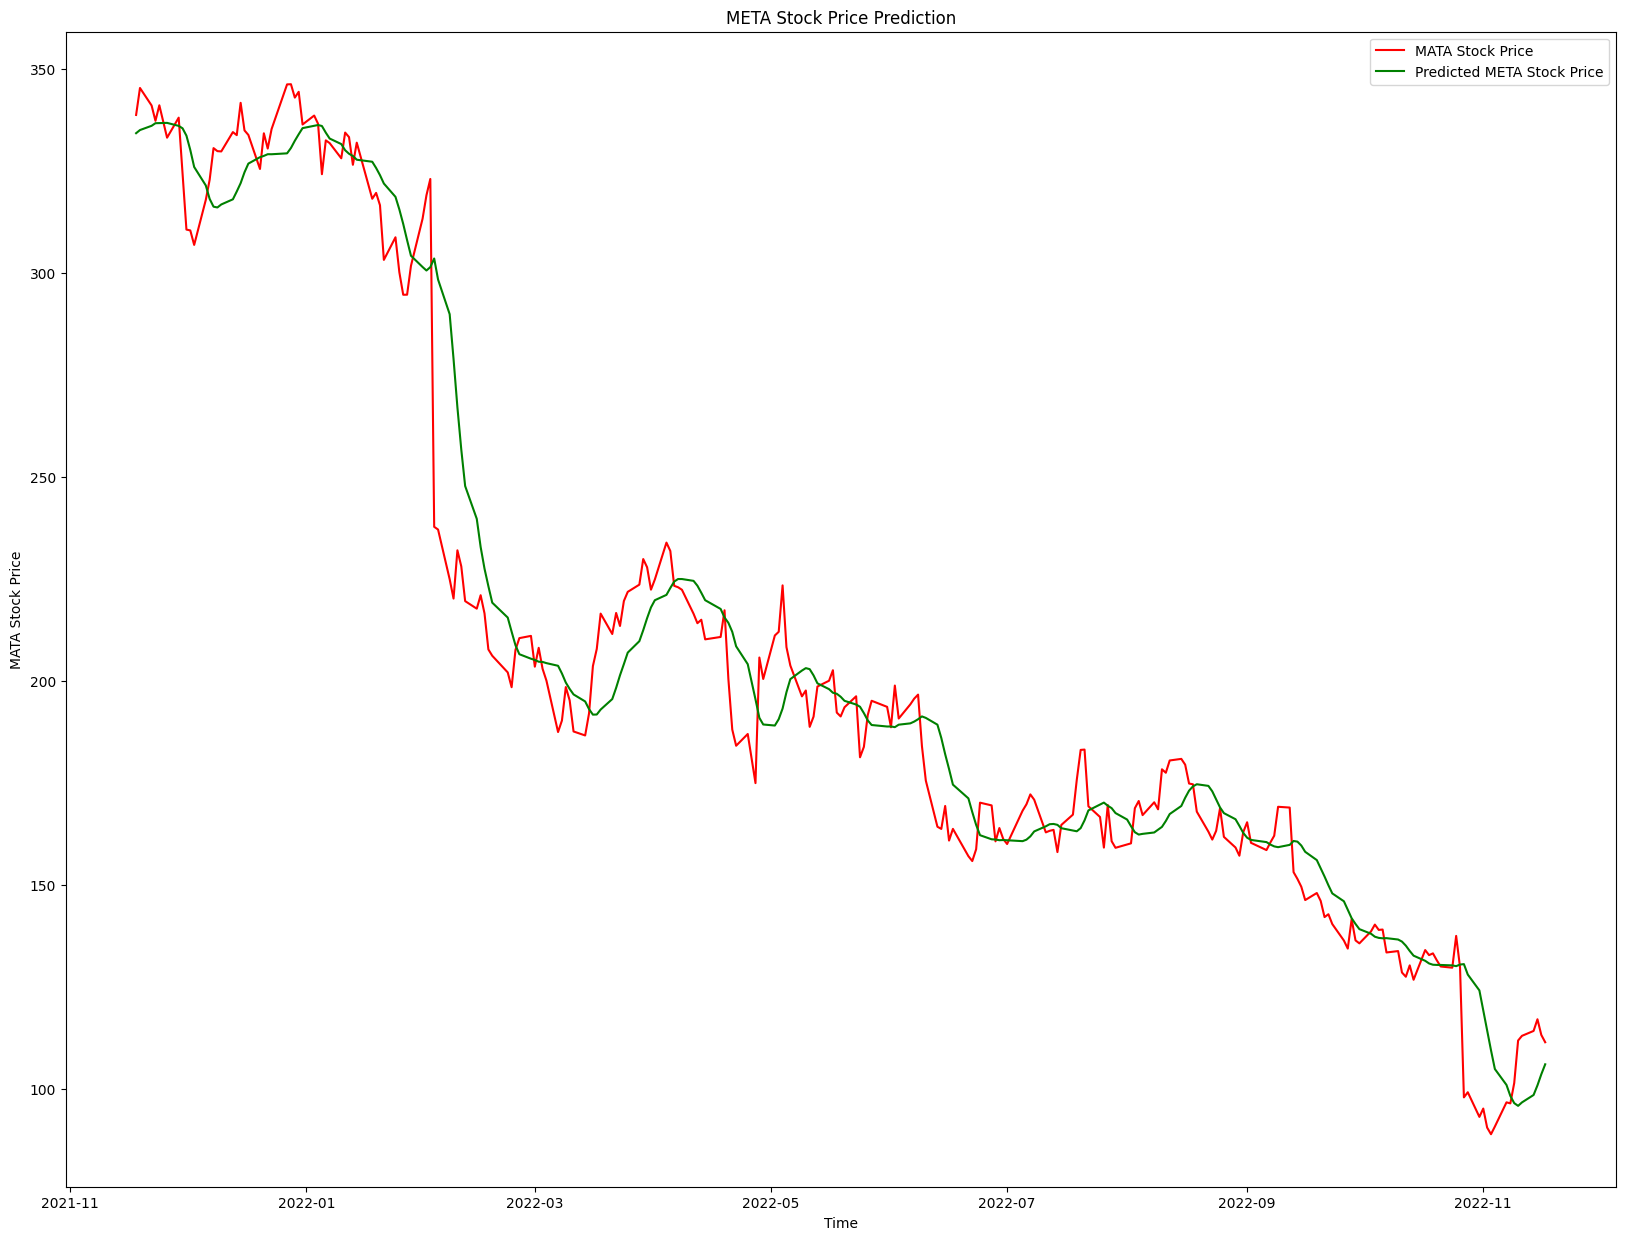

In [124]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test2=[]
for i in range(60,inputs_data2.shape[0]):
    X_test2.append(inputs_data2[i-60:i,0])
X_test2=np.array(X_test2)
X_test2=np.reshape(X_test2,(X_test2.shape[0],X_test2.shape[1],1))
predicted_closing_price2=lstm_model2.predict(X_test2)
predicted_closing_price2=scaler.inverse_transform(predicted_closing_price2)
#Save the LSTM model
lstm_model2.save("saved_model_META.h5")

#Visualize the predicted stock costs with actual stock costs
train_data2=new_dataset2[:1007]
valid_data2=new_dataset2[1007:]
valid_data2['Predictions']=predicted_closing_price2

plt.plot(valid_data2['Close'], color = 'red', label = 'MATA Stock Price')
plt.plot(valid_data2['Predictions'], color = 'green', label = 'Predicted META Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MATA Stock Price')

# displaying the title
plt.title("META Stock Price Prediction")
plt.show()

### Build and train the LSTM model for Microsoft

In [132]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data3=df3.sort_index(ascending=True,axis=0)
new_dataset3=pd.DataFrame(index=range(0,len(df3)),columns=['Date','Close'])
for i in range(0,len(data3)):
    new_dataset3["Date"][i]=data3['Date'][i]
    new_dataset3["Close"][i]=data3["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset3.index=new_dataset3.Date
new_dataset3.drop("Date",axis=1,inplace=True)
final_dataset3=new_dataset3.values

train_data3=final_dataset3[0:1007,:]
valid_data3=final_dataset3[1007:,:]

scaled_data3=scaler.fit_transform(final_dataset3)
x_train_data3,y_train_data3=[],[]
for i in range(60,len(train_data3)):
    x_train_data3.append(scaled_data3[i-60:i,0])
    y_train_data3.append(scaled_data3[i,0])

x_train_data3,y_train_data3=np.array(x_train_data3),np.array(y_train_data3)
x_train_data3=np.reshape(x_train_data3,(x_train_data3.shape[0],x_train_data3.shape[1],1))

#Build and train the LSTM model:
lstm_model3=Sequential()
lstm_model3.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data3.shape[1],1)))
lstm_model3.add(LSTM(units=50))
lstm_model3.add(Dense(1))
inputs_data3=new_dataset3[len(new_dataset3)-len(valid_data3)-60:].values
inputs_data3=inputs_data3.reshape(-1,1)
inputs_data3=scaler.transform(inputs_data3)
lstm_model3.compile(loss='mean_squared_error',optimizer='adam')
lstm_model3.fit(x_train_data3,y_train_data3,epochs=1,batch_size=1,verbose=2)

2022-11-21 22:06:24.357789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 22:06:24.514019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 22:06:24.653295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 22:06:24.801224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 22:06:24.985394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


947/947 - 31s - loss: 0.0026 - 31s/epoch - 32ms/step


2022-11-21 22:06:52.633766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 22:06:52.696608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 22:06:52.798462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 41ms/step


/var/folders/p9/5_9zfv8x779996pp8x3dr8hr0000gn/T/ipykernel_84498/174300738.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data3['Predictions']=predicted_closing_price3


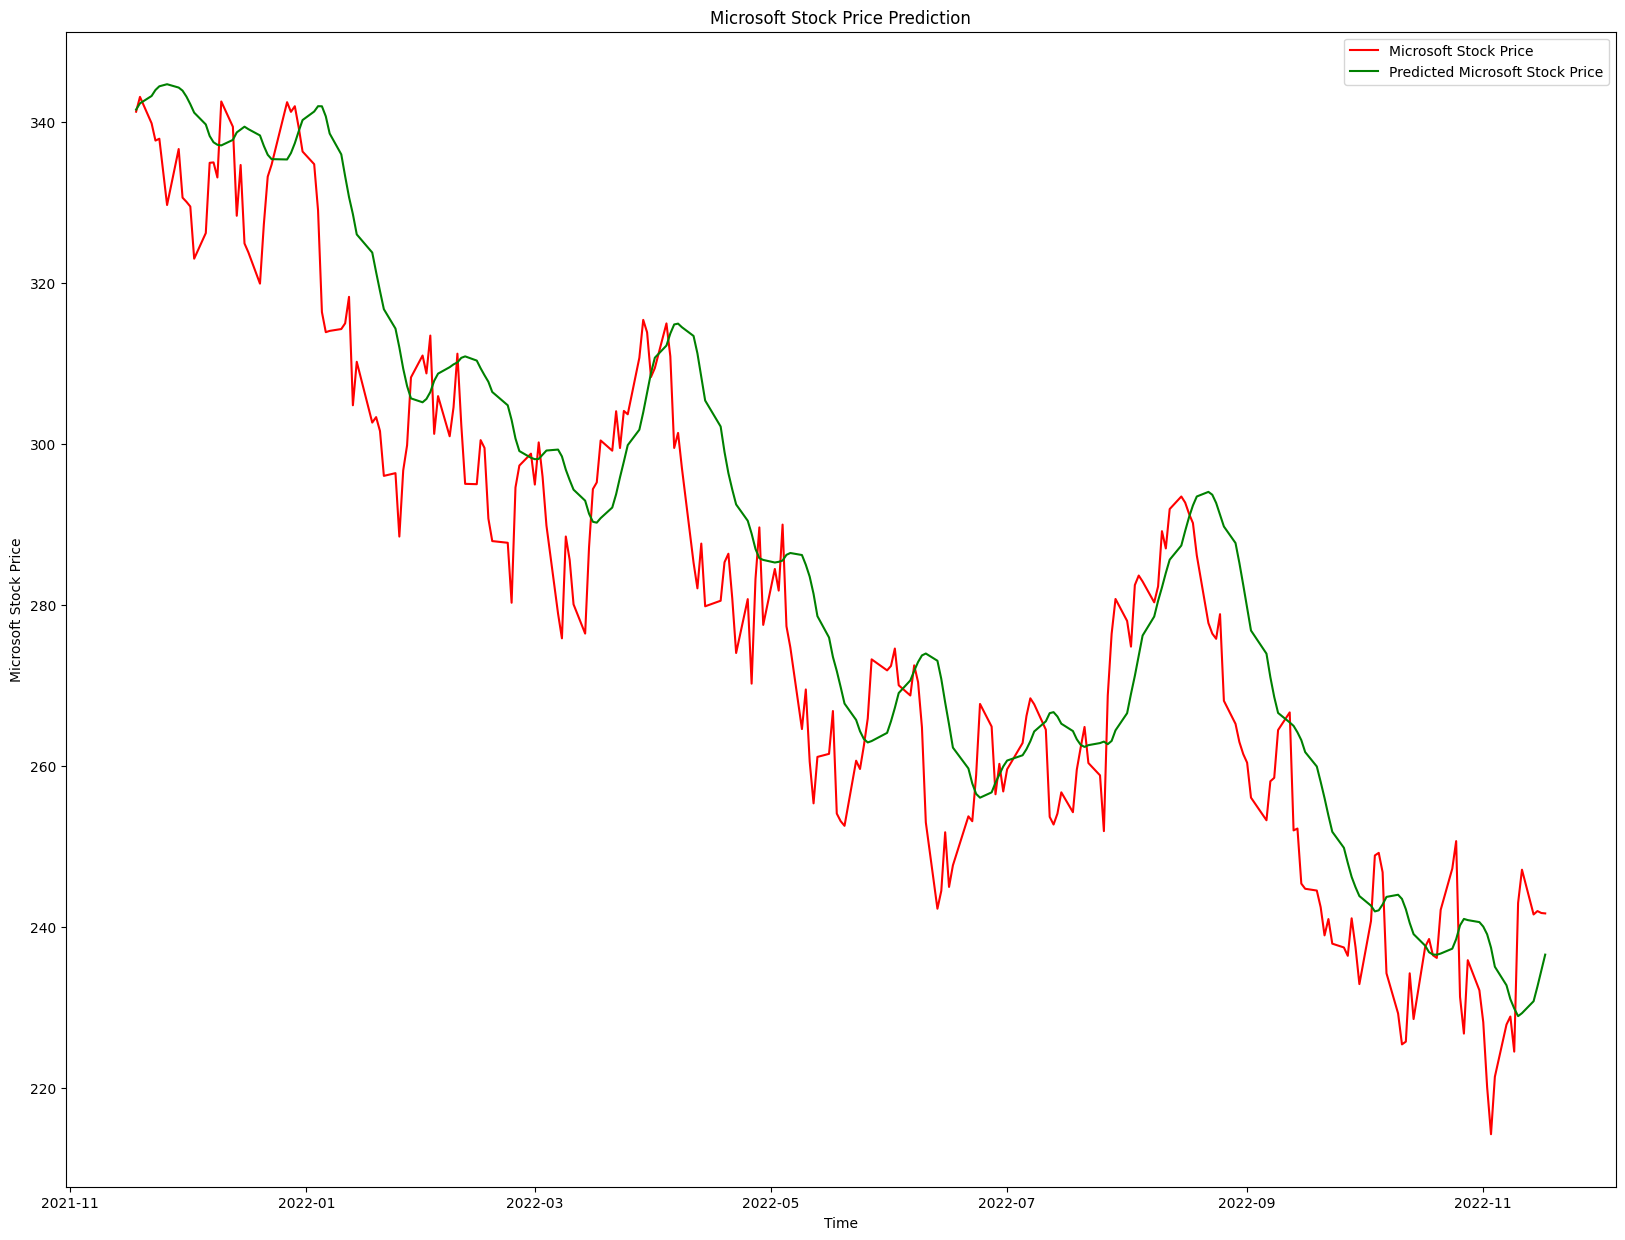

In [133]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test3=[]
for i in range(60,inputs_data3.shape[0]):
    X_test3.append(inputs_data3[i-60:i,0])
X_test3=np.array(X_test3)
X_test3=np.reshape(X_test3,(X_test3.shape[0],X_test3.shape[1],1))
predicted_closing_price3=lstm_model3.predict(X_test3)
predicted_closing_price3=scaler.inverse_transform(predicted_closing_price3)
#Save the LSTM model
lstm_model1.save("saved_model_MSFT.h5")

#Visualize the predicted stock costs with actual stock costs
train_data3=new_dataset3[:1007]
valid_data3 = new_dataset3[1007:]
valid_data3['Predictions']=predicted_closing_price3
#plt.plot(train_data1["Close"])
#plt.plot(valid_data1[['Close',"Predictions"]])
plt.plot(valid_data3['Close'], color = 'red', label = 'Microsoft Stock Price')
plt.plot(valid_data3['Predictions'], color = 'green', label = 'Predicted Microsoft Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')

# displaying the title
plt.title("Microsoft Stock Price Prediction")
plt.show()


### Build and train the LSTM model for Tesla

In [134]:
#Sort the dataset on date time and filter “Date” and “Close” columns
data4=df4.sort_index(ascending=True,axis=0)
new_dataset4=pd.DataFrame(index=range(0,len(df4)),columns=['Date','Close'])
for i in range(0,len(data4)):
    new_dataset4["Date"][i]=data4['Date'][i]
    new_dataset4["Close"][i]=data4["Close"][i]

#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset4.index=new_dataset4.Date
new_dataset4.drop("Date",axis=1,inplace=True)
final_dataset4=new_dataset4.values

train_data4=final_dataset4[0:1007,:]
valid_data4=final_dataset4[1007:,:]

scaled_data4=scaler.fit_transform(final_dataset4)
x_train_data4,y_train_data4=[],[]
for i in range(60,len(train_data4)):
    x_train_data4.append(scaled_data4[i-60:i,0])
    y_train_data4.append(scaled_data4[i,0])

x_train_data4,y_train_data4=np.array(x_train_data4),np.array(y_train_data4)
x_train_data4=np.reshape(x_train_data4,(x_train_data4.shape[0],x_train_data4.shape[1],1))

#Build and train the LSTM model:
lstm_model4=Sequential()
lstm_model4.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data4.shape[1],1)))
lstm_model4.add(LSTM(units=50))
lstm_model4.add(Dense(1))
inputs_data4=new_dataset4[len(new_dataset4)-len(valid_data4)-60:].values
inputs_data4=inputs_data4.reshape(-1,1)
inputs_data4=scaler.transform(inputs_data4)
lstm_model4.compile(loss='mean_squared_error',optimizer='adam')
lstm_model4.fit(x_train_data4,y_train_data4,epochs=1,batch_size=1,verbose=2)

2022-11-21 22:11:15.864742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 22:11:16.033740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 22:11:16.200315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 22:11:16.385233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 22:11:16.585006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


947/947 - 33s - loss: 0.0022 - 33s/epoch - 35ms/step


2022-11-21 22:13:46.801286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 22:13:46.912738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 22:13:47.147941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 2s 46ms/step


/var/folders/p9/5_9zfv8x779996pp8x3dr8hr0000gn/T/ipykernel_84498/3397457096.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data4['Predictions']=predicted_closing_price4


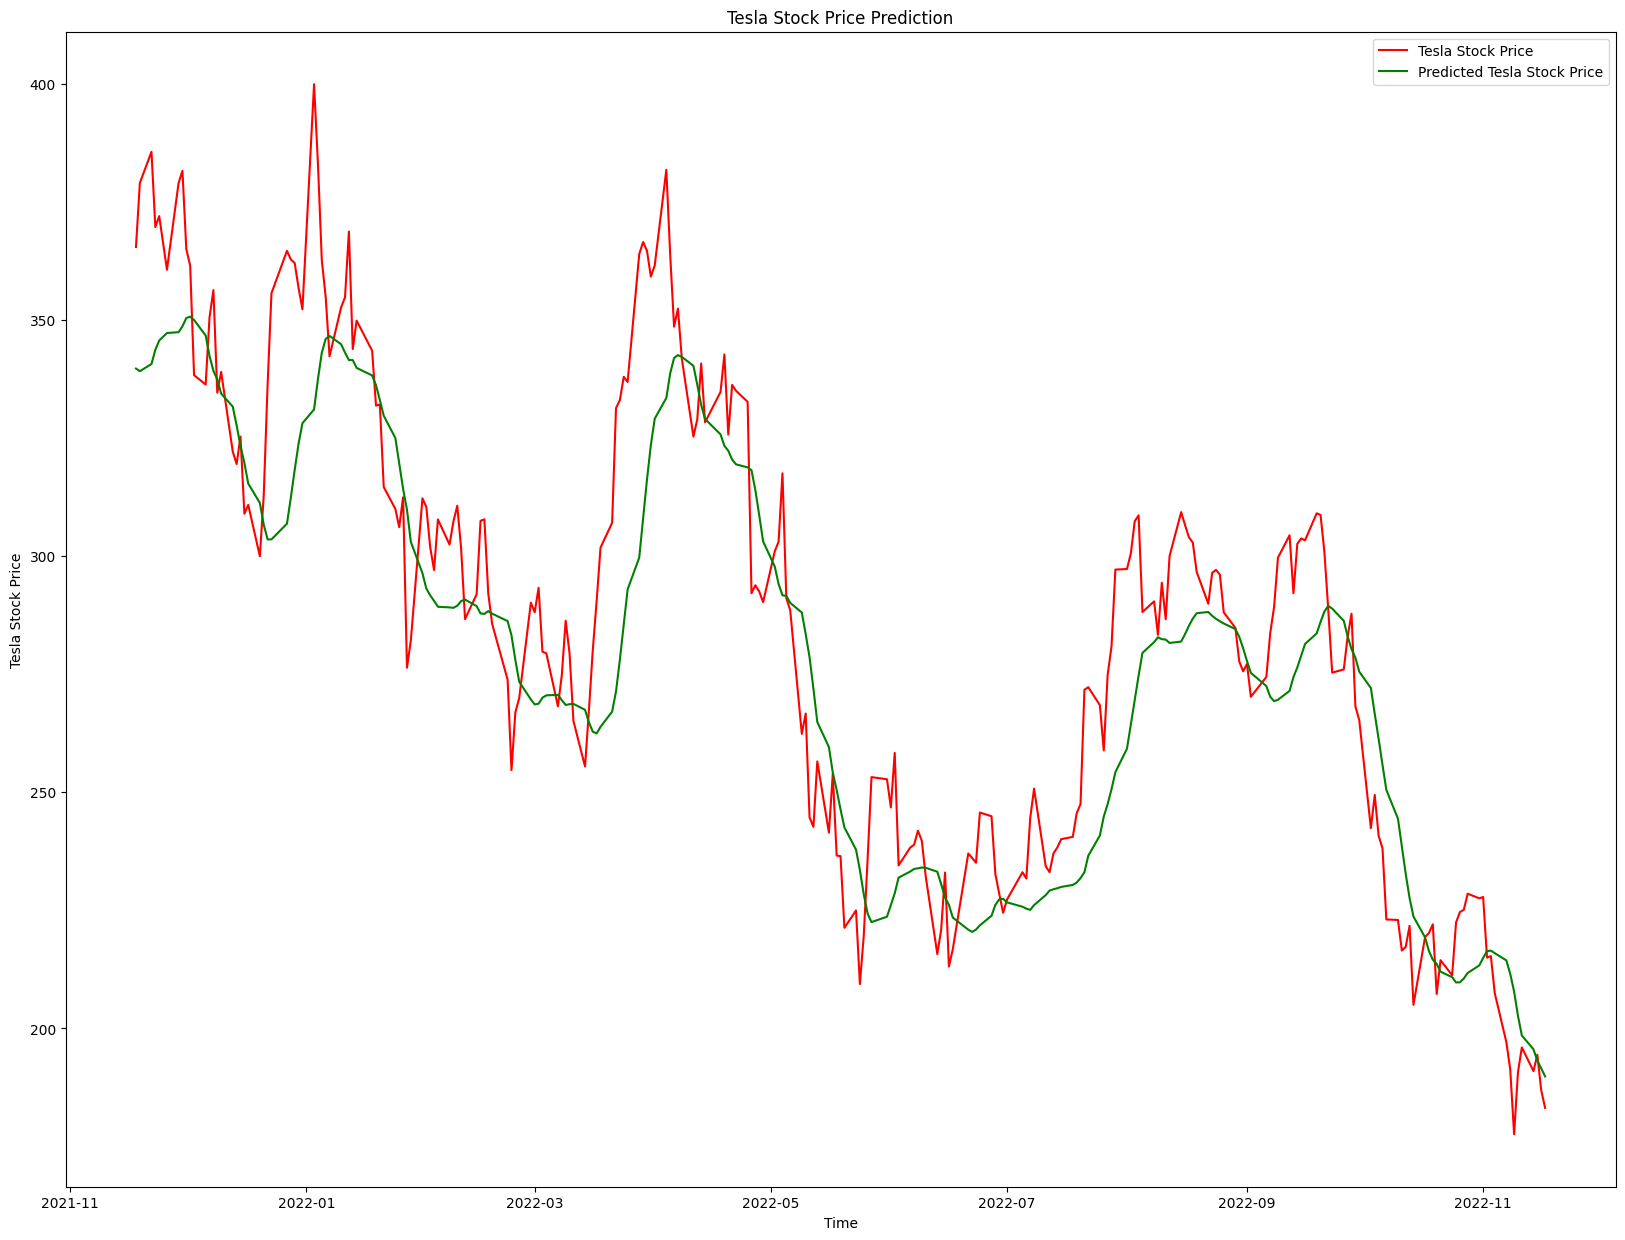

In [135]:
# Take a sample of a dataset to make stock price predictions using the LSTM model
X_test4=[]
for i in range(60,inputs_data4.shape[0]):
    X_test4.append(inputs_data4[i-60:i,0])
X_test4=np.array(X_test4)
X_test4=np.reshape(X_test4,(X_test4.shape[0],X_test4.shape[1],1))
predicted_closing_price4=lstm_model4.predict(X_test4)
predicted_closing_price4=scaler.inverse_transform(predicted_closing_price4)
#Save the LSTM model
lstm_model4.save("saved_model_TSLA.h5")

#Visualize the predicted stock costs with actual stock costs
train_data4=new_dataset4[:1007]
valid_data4 = new_dataset4[1007:]
valid_data4['Predictions']=predicted_closing_price4
#plt.plot(train_data1["Close"])
#plt.plot(valid_data1[['Close',"Predictions"]])
plt.plot(valid_data4['Close'], color = 'red', label = 'Tesla Stock Price')
plt.plot(valid_data4['Predictions'], color = 'green', label = 'Predicted Tesla Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')

# displaying the title
plt.title("Tesla Stock Price Prediction")
plt.show()


In [ ]:
!python3 stock_app.py